<a href="https://colab.research.google.com/github/carlosinator/cil-sentiment/blob/main/calibration_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Setup

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
%%bash
pip3 install transformers emoji==0.6.0 keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
!git clone https://github.com/carlosinator/cil-sentiment.git

Cloning into 'cil-sentiment'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 125 (delta 63), reused 17 (delta 4), pack-reused 0
Receiving objects: 100% (125/125), 163.85 KiB | 6.55 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras_nlp
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import pickle
import re
import subprocess as sp
import os
from threading import Thread , Timer
import sched, time

import sys
sys.path.append("./cil-sentiment/models")
sys.path.append("./cil-sentiment/")
from gru_models import GRUModel, VGRUModel
import utils

# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

Using TensorFlow backend


In [6]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

model_name = "vinai/bertweet-base"
filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
\ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
| [1 files][ 91.6 MiB/ 91.6 MiB]                                                
Operation completed over 1 objects/91.6 MiB.                                     


In [7]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

# split training / validation
batch_size = 1024 # * tpu_strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size
val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
test_ds = dataset.take(test_data_size).batch(batch_size, drop_remainder=True)
train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

<ipython-input-7-364751df9cd3>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-7-364751df9cd3>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Load in Model

In [24]:
USE_MODEL = "read" # alternatively 'read' or 'read-var'

run_name = "inference_" + USE_MODEL + "_fullmodel"
!gsutil cp -r {"gs://cil_2023/models/" + run_name} .

model = tf.keras.models.load_model(run_name)

Copying gs://cil_2023/models/inference_read_fullmodel/fingerprint.pb...
Copying gs://cil_2023/models/inference_read_fullmodel/keras_metadata.pb...
Copying gs://cil_2023/models/inference_read_fullmodel/saved_model.pb...
Copying gs://cil_2023/models/inference_read_fullmodel/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [4 files][527.7 MiB/527.7 MiB]   23.8 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://cil_2023/models/inference_read_fullmodel/variables/variables.index...
\ [5 files][527.7 MiB/5

# Calibration

In [25]:
labels = np.concatenate([y for x, y in test_ds])
output = model.predict(test_ds)

if USE_MODEL == "basemodel":
  preds = output["logits"]
  preds = tf.keras.layers.Softmax()(preds)
  preds = preds.numpy()
else:
  preds = output

221/221 [==============================] - 295s 1s/step


In [ ]:
NUM_BUCKETS = 10
positives = 1 - labels
pos_preds = preds[:,0]

In [39]:
def get_calibration_vecs(num_buckets, positives, pos_confidences):
  """
  create vectors required for calibration

  args:
  num_buckets (int) : number of buckets to create
  positives (np.array) : 1-D labels of data (1 if positive, 0 if negative)
  pos_confidences (np.array) : 1-D confidences in positivity of model

  returns: corr_frac, conf_frac, num_in_bucket
    corr_frac (np.array) : fraction of correct preds in buckets
    conf_frac (np.array) : mean confidence in each bucket
    num_in_bucket (np.array) : number of samples in each bucket

  """

  corr_frac = []
  conf_frac = []
  num_in_bucket = []

  for i in range(NUM_BUCKETS):
    mask = np.logical_and(pos_confidences >= i/NUM_BUCKETS, pos_confidences < (i+1)/NUM_BUCKETS)
    corr_frac.append(np.mean(positives[mask]))
    conf_frac.append(np.mean(pos_confidences[mask]))
    num_in_bucket.append(pos_confidences[mask].shape[0])


  corr_frac = np.array(corr_frac)
  conf_frac = np.array(conf_frac)
  num_in_bucket = np.array(num_in_bucket)


  return corr_frac, conf_frac, num_in_bucket


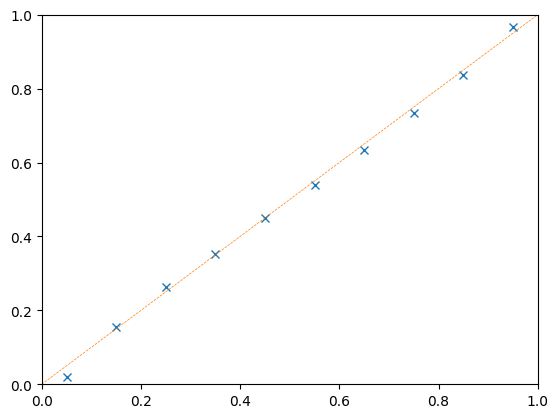

In [40]:
import matplotlib.pyplot as plt

corr_frac, conf_frac, num_in_bucket = get_calibration_vecs(NUM_BUCKETS, positives, pos_preds)


plt.plot(np.linspace(1/(2*NUM_BUCKETS), 1-1/(2*NUM_BUCKETS), NUM_BUCKETS), corr_frac, 'x')
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", linewidth=0.5)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [48]:
total = np.sum(num_in_bucket)

# expected calibration error
ece = (1/total) * np.sum(num_in_bucket * np.abs(corr_frac - conf_frac))

# max calibration error
mce = np.max(np.abs(corr_frac - conf_frac))

print(f"ECE: {ece:.6f}")
print(f"MCE: {mce:.6f}")

ECE: 0.005293
MCE: 0.019895
